In [4]:
import glob
import os
import scipy
import torch
import torch.nn as nn
import numpy as np
import flow_transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from imageio import imread

def load_flo(path):
    with open(path, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        assert(202021.25 == magic),'Magic number incorrect. Invalid .flo file'
        h = np.fromfile(f, np.int32, count=1)[0]
        w = np.fromfile(f, np.int32, count=1)[0]
        data = np.fromfile(f, np.float32, count=2*w*h)
    # Reshape data into 3D array (columns, rows, bands)
    data2D = np.resize(data, (w, h, 2))
    return data2D

def default_loader(root, path_imgs, path_flo, path_occ):
    imgs = [os.path.join(root,path) for path in path_imgs]
    flo = os.path.join(root,path_flo)
    occ = os.path.join(root,path_occ)
    return [imread(img).astype(np.float32) for img in imgs], load_flo(flo), imread(path_occ).astype(np.int32)

In [5]:
images = []
for flow_map in sorted(glob.glob(os.path.join('sintel','flow','ambush_4','*.flo'))):
    flow_map = os.path.relpath(flow_map, os.path.join('sintel','flow'))
    
    scene_dir, filename = os.path.split(flow_map)
    no_ext_filename = os.path.splitext(filename)[0]
    prefix, frame_nb = no_ext_filename.split('_')
    frame_nb = int(frame_nb)
    
    img1 = os.path.join('clean', scene_dir, '{}_{:04d}.png'.format(prefix, frame_nb))
    img2 = os.path.join('clean', scene_dir, '{}_{:04d}.png'.format(prefix, frame_nb+1))
    occ_mask = os.path.join('occlusions', scene_dir, '{}_{:04d}.png'.format(prefix, frame_nb))
    flow_map = os.path.join('flow', flow_map)
    
    if not (os.path.isfile(os.path.join('sintel',img1)) and os.path.isfile(os.path.join('sintel',img2))):
        continue
    images.append([[img1,img2], flow_map, occ_mask])

split_factor = 1.1     ## ratio of train split
split_values = np.random.uniform(0,1,len(images)) < split_factor
train_samples = [sample for sample, split in zip(images, split_values) if split]
test_samples = [sample for sample, split in zip(images, split_values) if not split]

#print(train_samples[0], test_samples[0])

occlusions/ambush_4/frame_0009.png
0.90588236


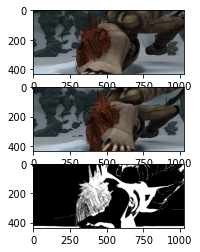

In [23]:
root = 'sintel'
index = 8

inputs, target, mask = train_samples[index] # or test_samples (path_list)
print(mask)

import matplotlib.image as mpimg
img1 = mpimg.imread(os.path.join(root, inputs[0]))
img2 = mpimg.imread(os.path.join(root, inputs[1]))
mask = mpimg.imread(os.path.join(root, mask))
mask = np.repeat(np.expand_dims(mask, axis=2), 3, axis=2)
print(img1.max())

fig = plt.figure()
a = fig.add_subplot(3, 1, 1)
imgplot = plt.imshow(img1)
a = fig.add_subplot(3, 1, 2)
imgplot = plt.imshow(img2)
a = fig.add_subplot(3, 1, 3)
imgplot = plt.imshow(mask)



In [ ]:
start_frame = 15
end_frame = 23
consistency_param = 50
moving_param = 0  ## 0.5

inputs, target, mask = train_samples[start_frame]
inputs, target, mask = default_loader(root, inputs, target, mask)
target = torch.from_numpy(target)

width = target.size(1)
height = target.size(0)

X = torch.Tensor([[range(height)]*width]).transpose(1,2)
Y = torch.Tensor([[range(width)]*height])
Grid = torch.cat([X,Y], 0).permute(1, 2, 0)

offset = torch.zeros(height, width, 2)
magnitude = torch.zeros(height, width, 2)
eliminate = torch.ones(height, width)

new_Grid = Grid.copy()
for ind in range(start_frame, end_frame):
    _, target, mask = train_samples[ind]
    target = load_flo(os.path.join(root, target))
    target = torch.from_numpy(target)
    mask = torch.from_numpy(mask)
    
    new_Grid[:,:,0] = torch.clamp((new_Grid + target.int())[:,:,0], 0, height-1)
    new_Grid[:,:,1] = torch.clamp((new_Grid + target.int())[:,:,1], 0, width-1)
    
    new_Grid[:,:,0] = 2.0*new_Grid[:,:,0].clone() / max(height-1,1)-1.0
    new_Grid[:,:,1] = 2.0*new_Grid[:,:,1].clone() / max(width-1,1)-1.0
    
    new_mask = nn.functional.grid_sample(mask, new_Grid)
    eliminate = eliminate * (1 - new_mask)
    #magnitude = magnitude + target.abs()

outputs, target, mask = train_samples[end_frame]    
outputs, _, mask = default_loader(root, outputs, target, mask)

source_points = (eliminate == 1).nonzero().transpose(0,1)
target_points = new_Grid[source_points[0], source_points[1]].long().transpose(0,1)

In [ ]:
##########################################################
###############    Valid Pixel Selection   ###############
##########################################################

In [ ]:
print(magnitude[:,:,0].max(), magnitude[:,:,1].max())
moving_pixels = ((magnitude[:,:,0] > height * moving_param) + (magnitude[:,:,1] > width * moving_param)).int()  ## H x W
source_points = moving_pixels.nonzero().transpose(0,1)   ## 2 x num_points

target_X = torch.clamp((Grid + offset.int())[:,:,0], 0, height-1)   ## H x W
target_Y = torch.clamp((Grid + offset.int())[:,:,1], 0, width-1)    ## H x W
target_Grid = torch.cat([target_X.unsqueeze(2), target_Y.unsqueeze(2)], 2)   ## H x W x 2

target_points = target_Grid[source_points[0], source_points[1]].long().transpose(0,1) ##  2 x num_points

source_image = torch.from_numpy(inputs[0])  ## H x W x 3
target_image = torch.from_numpy(outputs[1])  ## H x W x 3

source_value = source_image[source_points[0], source_points[1]]    ## num_points x 3
target_value = target_image[target_points[0], target_points[1]]    ## num_points x 3

diff = (source_value - target_value).norm(p=2, dim=1)
consistent_points = (diff < 100).nonzero().squeeze()  # 1 x num_con_points
print(consistent_points.size())

source_points = source_points.transpose(0,1)[consistent_points]  # 2 x num_con_points
target_points = target_points.transpose(0,1)[consistent_points]  # 2 x num_con_points

print(source_points.transpose(0,1), target_points.transpose(0,1))

In [ ]:
#########################################################
################   Image Preprocessing   ################
#########################################################

In [ ]:
####### Data Pre-processing #######

input_transform = transforms.Compose([
    flow_transforms.ArrayToTensor(),
    transforms.Normalize(mean=[0,0,0], std=[255,255,255]),
    transforms.Normalize(mean=[0.45,0.432,0.411], std=[1,1,1])
])
target_transform = transforms.Compose([
    flow_transforms.ArrayToTensor(),
    transforms.Normalize(mean=[0,0],std=[20,20])
])
## sparse ##
co_transform = flow_transforms.Compose([
    flow_transforms.RandomCrop((320,448)),
    flow_transforms.RandomVerticalFlip(),
    flow_transforms.RandomHorizontalFlip()
])

print(inputs[0].shape, target.shape)   ### Compare before & after data pre-processing ###
if co_transform is not None:
    inputs, target = co_transform(inputs, target)
if input_transform is not None:
    inputs[0] = input_transform(inputs[0])
    inputs[1] = input_transform(inputs[1])
if target_transform is not None:
    target = target_transform(target)

print(inputs[0][0,100:107,100:107])
print(target[0].max(), target[1].max())
print(inputs[0].size(), target.size())